In [ ]:
!pip install lightfm

     |████████████████████████████████| 317kB 27.6MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705335 sha256=00248c55ff5473368069033b68a28e42cd353d138cedc7488673f9439d653963
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('user_artists.dat', sep="\t", skiprows=1, names=['userID','artistID', 'weight'])
item_labels_csv = pd.read_csv('artistsWithGenreNew2.dat', sep='\t', skiprows=1, names=['id','name', 'url', 'pictureURL', 'genre'])
item_labels = item_labels_csv['name']
item_lables_index = item_labels_csv['id']



item_labels = item_labels.to_numpy()



In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('user_artists.dat', sep="\t", skiprows=1, names=['userID','artistID', 'weight'])
data = data.replace('?', np.NaN)
print('Número de instancias = %d' % (data.shape[0]))
print('Número de atributos = %d' % (data.shape[1]))
print('Valores faltantes:')
data.isnull().sum()

Número de instancias = 92834
Número de atributos = 3
Valores faltantes:


userID      0
artistID    0
weight      0
dtype: int64

In [3]:
dups = data.duplicated()
print('Lineas duplicadas: %d' % (dups.sum()))

Lineas duplicadas: 0


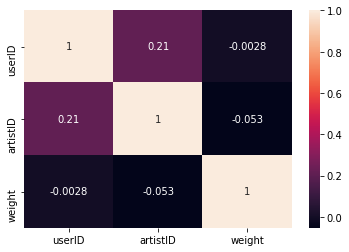

In [ ]:
import seaborn as sns
Var_Corr = data.corr()
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)

In [ ]:
import csv
item_labels_csv.to_csv(r'item_labels.csv',index=False)
data.to_csv(r'data.csv',index=False)
reader = csv.DictReader(open('item_labels.csv', 'r'))
dict_list = []
for line in reader:
      dict_list.append(line)
reader = csv.DictReader(open('data.csv', 'r'))
ratings = []
for line in reader:
      ratings.append(line)

In [ ]:
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score
import matplotlib.pyplot as plt
import time
dataset = Dataset()

dataset.fit((x['userID'] for x in ratings),(x['artistID'] for x in ratings))
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))
item_f=(x['name'] for x in dict_list)

dataset.fit_partial(items=(x['id'] for x in dict_list),
                    item_features=item_f)

item_features=dataset.build_item_features(((x['id'], [x['name']])for x in dict_list))
(interactions, weights) = dataset.build_interactions(((x['userID'], x['artistID'])
                                                      for x in ratings))


from lightfm.cross_validation import random_train_test_split
train,test=random_train_test_split(interactions, test_percentage=0.2, random_state=42)

alpha = 1e-05
epochs = 70
num_components = 32

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

Num users: 1892, num_items 17632.


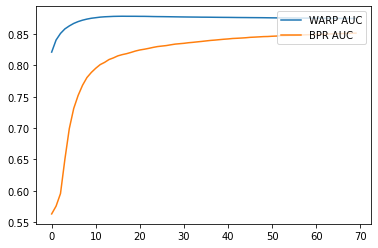

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

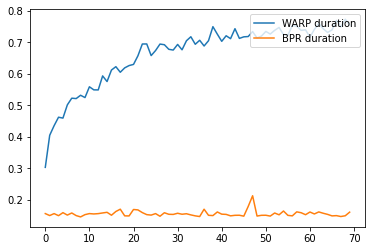

In [ ]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

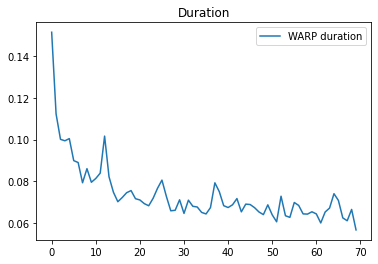

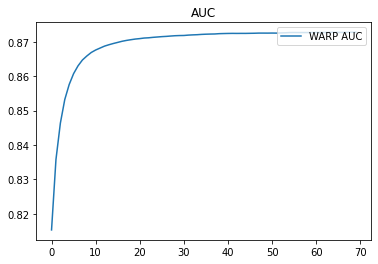

In [ ]:
warp_model = LightFM(no_components=num_components,
                     max_sampled=3,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
warp_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.legend(['WARP duration'], loc='upper right')
plt.title('Duration')
plt.show()

x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.legend(['WARP AUC'], loc='upper right')
plt.title('AUC')
plt.show()

Num users: 1892, num_items 17632.


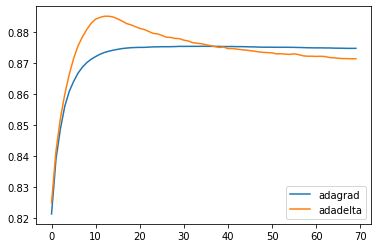

In [ ]:
alpha = 1e-3
epochs = 70
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score
import matplotlib.pyplot as plt
import time

dataset = Dataset()

dataset.fit((x['userID'] for x in ratings),(x['artistID'] for x in ratings))
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))
item_f=(x['name'] for x in dict_list)

dataset.fit_partial(items=(x['id'] for x in dict_list),
                    item_features=item_f)

item_features=dataset.build_item_features(((x['id'], [x['name']])for x in dict_list))
(interactions, weights) = dataset.build_interactions(((x['userID'], x['artistID'])
                                                      for x in ratings))


from lightfm.cross_validation import random_train_test_split
train,test=random_train_test_split(interactions, test_percentage=0.2, random_state=42)

alpha = 1e-05

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

def get_similar_tags(model, tag_id):
    # Define similarity as the cosine of the angle
    # between the tag latent vectors

    # Normalize the vectors to unit length
    tag_embeddings = (model.item_embeddings.T
                      / np.linalg.norm(model.item_embeddings, axis=1)).T
    
    query_embedding = tag_embeddings[tag_id]
    
    similarity = np.dot(tag_embeddings, query_embedding)
    
    most_similar = np.argsort(-similarity)[1:4]
    a = []
    for x in most_similar:
      if(x<17630):
        a.append(x)
    return a


for tag in (u'Justin Bieber', u'Eminem', u'Rihanna'):
    tag_id = tag_labels.tolist().index(tag)
    print('Most similar tags for %s: %s' % (tag_labels[tag_id],
                                            tag_labels[get_similar_tags(model, tag_id)]))  